# Hierarchical Clustering on Iris Dataset

Usage guidelines can be found in README.md of the repository this file resides in.

## Setup

Imports and loading data

In [1]:
from sklearn.datasets import load_iris
from sklearn.metrics import normalized_mutual_info_score as sk_nmi
from sklearn import preprocessing
from scipy.cluster import hierarchy
from functools import reduce
import operator as op
import matplotlib.pyplot as plt
import numpy as np

In [2]:
iris = load_iris()
iris.orig_data = iris.data
iris

{'data': array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2],
        [5.4, 3.9, 1.7, 0.4],
        [4.6, 3.4, 1.4, 0.3],
        [5. , 3.4, 1.5, 0.2],
        [4.4, 2.9, 1.4, 0.2],
        [4.9, 3.1, 1.5, 0.1],
        [5.4, 3.7, 1.5, 0.2],
        [4.8, 3.4, 1.6, 0.2],
        [4.8, 3. , 1.4, 0.1],
        [4.3, 3. , 1.1, 0.1],
        [5.8, 4. , 1.2, 0.2],
        [5.7, 4.4, 1.5, 0.4],
        [5.4, 3.9, 1.3, 0.4],
        [5.1, 3.5, 1.4, 0.3],
        [5.7, 3.8, 1.7, 0.3],
        [5.1, 3.8, 1.5, 0.3],
        [5.4, 3.4, 1.7, 0.2],
        [5.1, 3.7, 1.5, 0.4],
        [4.6, 3.6, 1. , 0.2],
        [5.1, 3.3, 1.7, 0.5],
        [4.8, 3.4, 1.9, 0.2],
        [5. , 3. , 1.6, 0.2],
        [5. , 3.4, 1.6, 0.4],
        [5.2, 3.5, 1.5, 0.2],
        [5.2, 3.4, 1.4, 0.2],
        [4.7, 3.2, 1.6, 0.2],
        [4.8, 3.1, 1.6, 0.2],
        [5.4, 3.4, 1.5, 0.4],
        [5.2, 4.1, 1.5, 0.1],
  

In [3]:
# normalize data
iris.norm_data = preprocessing.scale(iris.orig_data)
iris.norm_data

array([[-9.00681170e-01,  1.01900435e+00, -1.34022653e+00,
        -1.31544430e+00],
       [-1.14301691e+00, -1.31979479e-01, -1.34022653e+00,
        -1.31544430e+00],
       [-1.38535265e+00,  3.28414053e-01, -1.39706395e+00,
        -1.31544430e+00],
       [-1.50652052e+00,  9.82172869e-02, -1.28338910e+00,
        -1.31544430e+00],
       [-1.02184904e+00,  1.24920112e+00, -1.34022653e+00,
        -1.31544430e+00],
       [-5.37177559e-01,  1.93979142e+00, -1.16971425e+00,
        -1.05217993e+00],
       [-1.50652052e+00,  7.88807586e-01, -1.34022653e+00,
        -1.18381211e+00],
       [-1.02184904e+00,  7.88807586e-01, -1.28338910e+00,
        -1.31544430e+00],
       [-1.74885626e+00, -3.62176246e-01, -1.34022653e+00,
        -1.31544430e+00],
       [-1.14301691e+00,  9.82172869e-02, -1.28338910e+00,
        -1.44707648e+00],
       [-5.37177559e-01,  1.47939788e+00, -1.28338910e+00,
        -1.31544430e+00],
       [-1.26418478e+00,  7.88807586e-01, -1.22655167e+00,
      

In [4]:
labels = []
counter = -1
current = iris.target[0]
for l in iris.target:
    if l == current:
        counter += 1
    else:
        current = l
        counter = 0
    labels.append(str(l)+":"+str(counter))

In [5]:
weights = [1,1,1,1]

## Distance functions

Manhattan and vector distance

In [6]:
# one and two are lists of length 4, corresponding to the 4 cols in iris.data
def manhattan_dist(one, two):
    dist = 0
    for i in range(4):
        dist += abs(one[i] - two[i]) * weights[i]
        
    return dist

In [7]:
def vector_dist(one, two):
    dist = 0
    for i in range(4):
        dist += abs(one[i] - two[i]) ** 2 * weights[i]
        
    return dist ** .5

## Cluster Similarity Functions

Simple (closest two datapoints), complete (farthest two datapoints), and average (average of datapoints).

In [8]:
# one and two are both clusters represented as lists of indices
def simple_distance(one, two, dist_metric):
    dist = dist_metric(iris.data[one[0]], iris.data[two[0]])
    for one_elem in one:
        for two_elem in two:
            cur_dist = dist_metric(iris.data[one_elem], iris.data[two_elem])
            if cur_dist < dist:
                dist = cur_dist
                
    return dist

In [9]:
# one and two are both clusters represented as lists of indices
def complete_distance(one, two, dist_metric):
    dist = dist_metric(iris.data[one[0]], iris.data[two[0]])
    for one_elem in one:
        for two_elem in two:
            cur_dist = dist_metric(iris.data[one_elem], iris.data[two_elem])
            if cur_dist > dist:
                dist = cur_dist
                
    return dist

In [10]:
# one and two are both clusters represented as lists of indices
# should use weights for this one?
def average_distance(one, two, dist_metric):
    one_avg = [0.,0.,0.,0.]
    for one_elem in one:
        one_avg[0] += iris.data[one_elem][0]
        one_avg[1] += iris.data[one_elem][1]
        one_avg[2] += iris.data[one_elem][2]
        one_avg[3] += iris.data[one_elem][3]
    
    one_avg[0] /= len(one)
    one_avg[1] /= len(one)
    one_avg[2] /= len(one)
    one_avg[3] /= len(one)
    
    two_avg = [0.,0.,0.,0.]
    for two_elem in two:
        two_avg[0] += iris.data[two_elem][0]
        two_avg[1] += iris.data[two_elem][1]
        two_avg[2] += iris.data[two_elem][2]
        two_avg[3] += iris.data[two_elem][3]
    
    two_avg[0] /= len(two)
    two_avg[1] /= len(two)
    two_avg[2] /= len(two)
    two_avg[3] /= len(two)
    
    return dist_metric(one_avg, two_avg)

## Helper Functions

In [11]:
def make_condensed_dist_mat(fun, dist_metric):
    dists = []
    for i in range(len(iris.data)):
        for j in range(i+1, len(iris.data)):
            dist = fun(list([i]), list([j]), dist_metric)
            dists.append(dist)
            
    return dists

In [12]:
def find_clusters(Z, pick_left=True):
    # five possible cases to choose three clusters, assuming num_leafs >= 3
    num_leafs = len(iris.data)
    root_cluster = Z[len(Z)-1]
    
    # 1. leaf is left cluster of root cluster
    if root_cluster[0] < len(iris.data):
        child_cluster = Z[root_cluster[1]-num_leafs]
        cluster_indices = [root_cluster[0], child_cluster[0], child_cluster[1]]
    
    # 2. leaf is right cluster of root cluster
    elif root_cluster[1] < len(iris.data):
        child_cluster = Z[root_cluster[0]-num_leafs]
        cluster_indices = [root_cluster[1], child_cluster[0], child_cluster[1]]
        
    # 3. children of root cluster have equal distance-measures in Z
    else:
        left_cluster = Z[root_cluster[0]-num_leafs]
        right_cluster = Z[root_cluster[1]-num_leafs]
        
        if left_cluster[2] == right_cluster[2]:
            if pick_left:
                cluster_indices = [left_cluster[0], left_cluster[1], root_cluster[1]]
            else:
                cluster_indices = [right_cluster[0], right_cluster[1], root_cluster[0]]
    
    # 4. left child of root has higher distance-measure in Z
        elif left_cluster[2] > right_cluster[2]:
            cluster_indices = [left_cluster[0], left_cluster[1], root_cluster[1]]
            
    # 5. right child of root has higher distance-measure in Z
        else:
            cluster_indices = [right_cluster[0], right_cluster[1], root_cluster[0]]
                
    clusters = []
    for head in cluster_indices:
        cluster = []
        to_process = [head]
        while len(to_process) > 0:
            cur = int(to_process[0])
            to_process.pop(0)
            
            if cur < len(iris.data):
                cluster.append(cur)
            else:
                one = Z[cur-num_leafs][0]
                two = Z[cur-num_leafs][1]
                to_process.append(one)
                to_process.append(two)
                
        clusters.append(cluster)
                
    return cluster_indices, clusters

In [13]:
def make_cluster_label_map(cluster_indices, clusters):
    label_counts = { i : {0: 0, 1: 0, 2: 0} for i in cluster_indices}
    for i in range(len(cluster_indices)):
        index = cluster_indices[i]
        cluster = clusters[i]
        
        for elem in cluster:
            label = iris.target[elem]
            label_counts[index][label] += 1
            
    return label_counts

## Cluster Evaluation Functions

Purity, Rand index, and normalized mutual information (NMI)

In [14]:
def purity(cluster_indices, clusters):
    label_counts = make_cluster_label_map(cluster_indices, clusters)
    
    correctly_assigned = 0
    for cluster_index in label_counts:
        cluster = label_counts[cluster_index]
        if cluster[0] >= cluster[1] and cluster[0] >= cluster[2]:
            cluster_label = 0
            correctly_assigned += cluster[0]
        elif cluster[1] >= cluster[0] and cluster[1] >= cluster[2]:
            cluster_label = 1
            correctly_assigned += cluster[1]
        else:
            cluster_label = 2
            correctly_assigned += cluster[2]
            
    return correctly_assigned / len(iris.data)

In [15]:
# https://stackoverflow.com/questions/4941753/is-there-a-math-ncr-function-in-python
def ncr(n, r):
    r = min(r, n-r)
    numer = reduce(op.mul, range(n, n-r, -1), 1)
    denom = reduce(op.mul, range(1, r+1), 1)
    return numer // denom

# https://nlp.stanford.edu/IR-book/html/htmledition/evaluation-of-clustering-1.html
# https://stats.stackexchange.com/questions/15158/precision-and-recall-for-clustering
def RI(cluster_indices, clusters): 
    label_counts = make_cluster_label_map(cluster_indices, clusters)
    
    tp, fp, allp, tn, fn, alln, N = 0, 0, 0, 0, 0, 0, 0
    label_distr = { i : [0, 0, 0] for i in range(3) }
    for i in range(len(cluster_indices)): # should be equivalent to range(3)
        cluster_index = cluster_indices[i]
        cluster = label_counts[cluster_index]
        cluster_size = len(clusters[i])
        N += cluster_size
        
        allp += ncr(cluster_size, 2)
        for l in range(3):
            cur = cluster[l]
            if cur >= 2:
                tp += ncr(cur, 2)
            label_distr[l][i] += cur
            
    fp = allp - tp
    alln = ncr(N, 2) - allp
    
    for i in range(len(label_distr)): # should be equivalent to range(3)
        cur_distr = label_distr[i]
        fn += cur_distr[0] * cur_distr[1] + cur_distr[0] * cur_distr[2] + cur_distr[1] * cur_distr[2]
        
    tn = alln - fn
    
    return (tp + tn)/(tp + fp + fn + tn)
        

In [16]:
# https://nlp.stanford.edu/IR-book/html/htmledition/evaluation-of-clustering-1.html
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.normalized_mutual_info_score.html
def NMI(cluster_indices, clusters):    
    expected = iris.target
    actual = [-1 for i in range(len(expected))]
    label_counts = make_cluster_label_map(cluster_indices, clusters)
    
    for i in range(len(cluster_indices)):
        cluster_index = cluster_indices[i]
        cluster = clusters[i]
        labels = label_counts[cluster_index]
        if labels[0] >= labels[1] and labels[0] >= labels[2]:
            cluster_label = 0
        elif labels[1] >= labels[0] and labels[1] >= labels[2]:
            cluster_label = 1
        else:
            cluster_label = 2
            
        for leaf in cluster:
            actual[leaf] = cluster_label
            
    return sk_nmi(expected, actual, average_method='arithmetic')

## Clustering Function

In [17]:
def cluster(distance_func, dist_metric):
    num_leafs = len(iris.data)
    clusters = { i : [i] for i in range(num_leafs)}
    
    # init distances for original data points
    distances = {}
    for i in range(num_leafs):
        if i not in distances:
            distances[i] = {}
        for j in range(i+1, num_leafs):
            if not j in distances:
                distances[j] = {}
            dist = dist_metric(iris.data[i], iris.data[j])
            distances[i][j] = dist
            distances[j][i] = dist
        
    Z = []
    
    #form clusters
    next_cluster = num_leafs
    while len(clusters) > 1:
        # find closest clusters
        dist, c1, c2 = np.inf, None, None     
        for i in clusters:
            for j in clusters:
                if i == j:
                    continue
                cur_dist = distances[i][j]
                if cur_dist < dist:
                    dist = cur_dist
                    c1 = i
                    c2 = j
                    
        #print("New cluster ", next_cluster, " combining ", c1, "and", c2)
                
        # create new cluster
        cluster_leaves = clusters[c1] + clusters[c2]
        clusters[next_cluster] = cluster_leaves
        
        # find distances between all other clusters and the new one
        distances[next_cluster] = {}
        for i in clusters:
            if i == next_cluster or i == c1 or i == c2:
                continue
            cur_dist = distance_func(clusters[i], cluster_leaves, dist_metric)
            distances[next_cluster][i] = cur_dist
            distances[i][next_cluster] = cur_dist
            
            del distances[i][c1]
            del distances[i][c2]
        
        # delete old clusters
        del clusters[c1]
        del clusters[c2]
        del distances[c1]
        del distances[c2]
        
        # append to Z
        Z.append([c1, c2, dist, len(cluster_leaves)])
        
        # increment next cluster
        next_cluster += 1
        
    return Z

In [18]:
def cluster_and_analyze(normalized, distance_func, dist_metric, use_weights=[1,1,1,1]):
    weights = use_weights
    
    if normalized:
        iris.data = iris.norm_data
    else:
        iris.data = iris.orig_data
        
    Z = cluster(distance_func, dist_metric)
    
    plt.figure(figsize=(14, 6), dpi=80)
    dn = hierarchy.dendrogram(Z, labels=labels, leaf_rotation=90)
    plt.show()
    
    cluster_indices, clusters = find_clusters(Z)
    print(cluster_indices)
    print("purity:", purity(cluster_indices, clusters))
    print("RI:", RI(cluster_indices, clusters))
    print("NMI:", NMI(cluster_indices, clusters))

## Playground

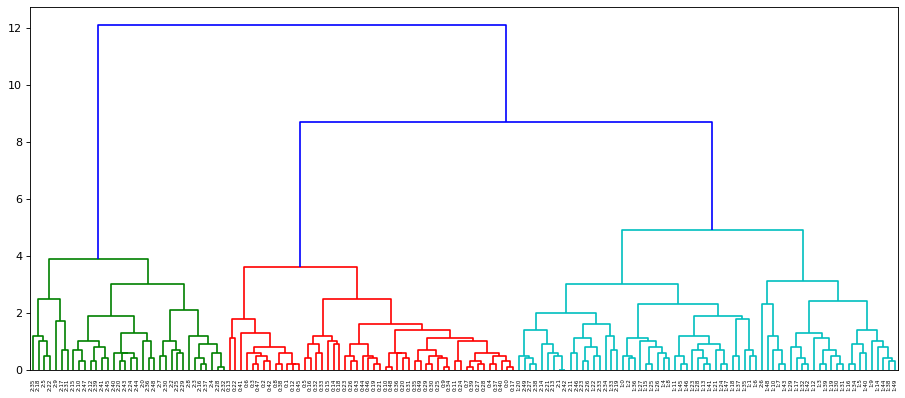

[294, 296, 295]
purity: 0.8933333333333333
RI: 0.8797315436241611
NMI: 0.7906785790830966


In [19]:
cluster_and_analyze(False, complete_distance, manhattan_dist, use_weights=[1,2,4,5])